1. Explore dataset. Open an image.

In [6]:
import os
from os import listdir
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

1200 images in total
This is the first image.


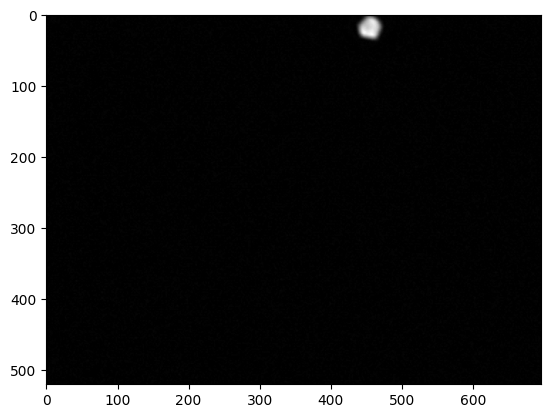

In [7]:
# folder path for images:
# fpath = 'C:/Users/SchumA01/OneDrive - Johnson Matthey/Documents/ML_AI_course_Imperial/25_portfolio_project/project/BBBC008_v1_images/human_ht29_colon_cancer_2_images'
fpath = 'C:/Users/SchumA01/OneDrive - Johnson Matthey/Documents/ML_AI_course_Imperial/25_portfolio_project/project/BBBC005_v1_images'

# print(os.listdir(fpath)[1])

images = []
for img in os.listdir(fpath): # within the folder, load image to images list if it is a channel1 tif image
    if img.endswith(".TIF") and 'F1' in img:
        images.append(img)

print(len(images), 'images in total')

# show first image:
print('This is the first image.')
plt.imshow(Image.open(fpath + '/' + images[0]), cmap = 'gray');

2. Load all images and masks and divide into training and test sets. Save in the unet folder's imgs and masks folders.

1200 masks in total
This is the first mask.


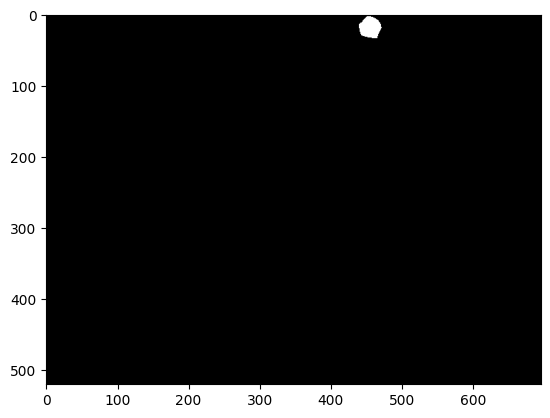

In [13]:
# mask folder path:
# fpath_m = 'C:/Users/SchumA01/OneDrive - Johnson Matthey/Documents/ML_AI_course_Imperial/25_portfolio_project/project/BBBC008_v1_foreground/human_ht29_colon_cancer_2_foreground'
fpath_m = 'C:/Users/SchumA01/OneDrive - Johnson Matthey/Documents/ML_AI_course_Imperial/25_portfolio_project/project/BBBC005_v1_ground_truth/BBBC005_v1_ground_truth'

masks = []
for m in os.listdir(fpath_m):
    if m.endswith(".TIF") and 'F1' in m:
        masks.append(m)

print(len(masks), 'masks in total')

plt.imshow(Image.open(fpath_m + '/' + masks[0]), cmap = 'gray');
print('This is the first mask.')

In [14]:
# train test split:
length = len(images)
split = int(np.round(0.5*length)) # 0.5 means using 50/50 split

train_i = images[:split]
train_m = masks[:split]
test_i = images[split:]
test_m = masks[split:]

In [19]:
# Save training sets in folders:
i = 0
for img in train_i:
    i += 1
    p = 'data/imgs/'+str(i)+'.tif'
    img = Image.open(fpath + '/' + img)
    img.save(p)

i = 0
for m in train_m:
    i += 1
    p = 'data/masks/'+str(i)+'.tif'
    m = Image.open(fpath_m + '/' + m)
    m.save(p)

3. Train a unet on the training set.

In [1]:
import unet
import train
import torch

In [2]:
net = unet.UNet(n_channels=1, n_classes=2, bilinear=False)
device = torch.device('cuda') if torch.cuda.is_available() else 'cpu'
net.to(device=device);

train.train_model(model = net,
          device = device,
          epochs = 5,
          batch_size = 1,
          learning_rate = 1e-3,
          val_percent = 0.1,
          save_checkpoint = True,
          img_scale = 0.5,
          amp = False)

Epoch 5/5: 100%|██████████| 540/540 [03:25<00:00,  2.62img/s, loss (batch)=0.013]   


4. Load and test the unet.

In [3]:
from predict import predict_img

In [4]:
net = unet.UNet(n_channels=1, n_classes=2)

net.to(device=device)
net.load_state_dict(torch.load(r"checkpoints/checkpoint_epoch5.pth", map_location=device))

<All keys matched successfully>

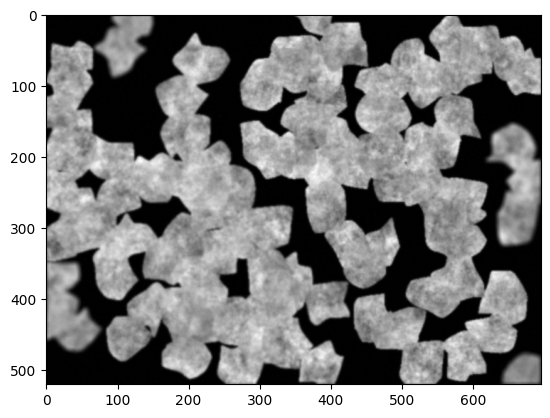

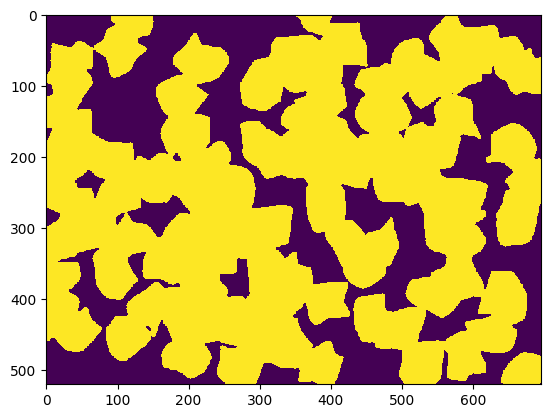

In [11]:
img = Image.open(fpath + '/' + images[len(images)-1])
# print(img.size)

pred = predict_img(net,
                img,
                device,
                # scale_factor=1,
                # out_threshold=0.9
                )

# print(pred.shape)
plt.imshow(img, cmap='gray')
plt.figure()
plt.imshow(pred,interpolation='none');

5. Calculate F1 score.

In [38]:
# get predictions on test images, convert them and corresponding masks to 1D arrays
preds = np.empty(0)
for t in test_i:
    newpred = predict_img(net, Image.open(fpath + '/' + t), device)
    preds = np.append(preds, newpred.reshape(np.product(newpred.shape)))

mask_array = np.empty(0)
for m in test_m:
    newmask = np.asarray(Image.open(fpath_m + '/' + m))/255 # division by 255 to match unet predictions
    mask_array = np.append(mask_array, newmask.reshape(np.product(newmask.shape)))

In [42]:
from sklearn.metrics import f1_score

# evaluate each pixel (true positive = true particle, false positive, etc.)
f1 = f1_score(mask_array, preds)
print('The F1 score is', '{:.3f}'.format(f1), '.')

The F1 score is 0.971525828668896


In [49]:
print('The F1 score is', '{:.3f}'.format(f1))

The F1 score is 0.972
